# Import

In [1]:
# Setup: imports, reproducibility, plotting defaults
import numpy as np
import pandas as pd
import math
from pprint import pprint
import os
import matplotlib.pyplot as plt
#Keras:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers


from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
import seaborn as sns

from scipy.stats import ks_2samp

import itertools
from pprint import pprint

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(42)  # reproducible

# Data Loading & Preprocessing

## All Channels

In [2]:
TBar_file_path = 'data/dataset=TTbarPowheg_Dilepton.parquet'
VLL_file_path = 'data/dataset=VLL_NN_EE_EN_M-600GeV.parquet'

# Read the Parquet file into a DataFrame
dfB = pd.read_parquet(TBar_file_path) #background dataset
dfS = pd.read_parquet(VLL_file_path) #signal dataset

pd.set_option('display.max_columns', None)
# Display the first few rows of the DataFrame
# Each row is an event
display(dfB.head())
display(dfB.shape)
display(dfS.head())
display(dfS.shape)

,dxy,dxyErr,dz,dzErr,eta,ip3d,jetPtRelv2,jetRelIso,mass,miniPFRelIso_all,miniPFRelIso_chg,pfRelIso03_all,pfRelIso03_chg,phi,pt,sip3d,mvaTTH,charge,jetIdx,pdgId,tightCharge,isPFcand,jetNDauCharged,genPartIdx,genPartFlav,cleanmask,genPartIdxG,jetIdxG,event,lumi,run,event_MET,event_HT,event_bHT,Leading_Lepton_pt,event_invariant_mass_dilepton,dr_leptons,dr_lepton_jet,dr_lepton_bjet,leadlep_sublep_pt_ratio,max_dr_per_event,min_delta_r_per_event
0,-0.002493,0.001755,0.003771,0.002808,0.566162,0.004086,50.000000,0.014832,0.015060,0.000000,0.000000,0.008291,0.008291,-0.751953,89.339050,1.916992,0.918579,1,2,-11,2,True,1,15,1,1,408060,56841,7418943,7419,1,86.167610,662.085510,477.798828,89.339050,48.132481,0.753168,1.849253,1.849253,1.917095,3.706177,1.514557
1,-0.000049,0.001358,0.005169,0.002136,-0.695557,0.004128,30.562500,0.027344,0.029602,0.000000,0.000000,0.000000,0.000000,-0.865723,95.658302,2.375000,0.294281,-1,3,11,2,True,1,14,1,1,301121,41857,7485885,7486,1,78.785789,647.581116,647.581116,95.658302,196.062469,2.606218,3.909067,3.909067,2.185622,3.909067,0.812024
2,-0.000419,0.001785,0.000200,0.002441,0.574707,0.000453,4.109375,0.030579,0.006691,0.000000,0.000000,0.019600,0.019600,-2.712891,35.369534,0.246094,0.569092,1,5,-11,2,True,1,16,1,1,506921,70522,7447931,7448,1,142.601501,304.893799,257.195404,35.369534,48.230186,3.493644,5.387913,5.387913,2.261117,5.387913,0.486039
3,0.000342,0.001083,-0.004768,0.002625,-0.525146,0.004192,30.875000,0.018372,0.105713,0.000000,0.000000,0.000000,0.000000,-2.871094,108.726692,1.796875,0.998138,1,1,-13,2,True,2,67,15,1,136329,18879,7450679,7451,1,134.817825,841.440857,315.807831,108.726692,132.875427,1.432259,2.990857,2.990857,1.284647,5.753501,0.704983
4,0.000242,0.001099,-0.000070,0.002350,0.688110,0.000248,9.781250,0.166992,0.105713,0.012936,0.012936,0.199307,0.199307,-2.836426,45.747322,0.217041,0.995758,1,6,-13,2,True,2,17,1,1,178258,25054,7558478,7559,1,175.054108,912.636597,562.176208,45.747322,31.784460,0.746115,5.560124,5.560124,1.112546,5.965622,0.646082


(4288, 42)

,dxy,dxyErr,dz,dzErr,eta,ip3d,jetPtRelv2,jetRelIso,mass,miniPFRelIso_all,miniPFRelIso_chg,pfRelIso03_all,pfRelIso03_chg,phi,pt,sip3d,mvaTTH,charge,jetIdx,pdgId,tightCharge,isPFcand,jetNDauCharged,genPartIdx,genPartFlav,cleanmask,genPartIdxG,jetIdxG,event,lumi,run,event_MET,event_HT,event_bHT,Leading_Lepton_pt,event_invariant_mass_dilepton,dr_leptons,dr_lepton_jet,dr_lepton_bjet,leadlep_sublep_pt_ratio,max_dr_per_event,min_delta_r_per_event
0,0.000771,0.001465,0.001438,0.002045,0.544800,0.001467,13.562500,0.022522,-0.013092,0.0,0.0,0.016314,0.016314,-2.602051,145.340775,0.880859,0.940491,1,0,-11,2,True,2,38,15,1,1127,150,67017,671,1,83.211937,631.951111,480.344971,145.340775,225.401581,3.137270,0.483243,0.483243,1.738116,5.151549,0.483243
1,-0.003639,0.001419,0.001663,0.002808,0.681885,0.003878,34.375000,0.133301,-0.036743,0.0,0.0,0.000000,0.000000,0.290833,134.811447,2.457031,0.848785,-1,2,11,2,True,1,41,15,1,6334,864,67091,671,1,136.999390,670.411926,499.962158,134.811447,52.958672,0.541945,2.830548,2.830548,1.950107,3.371400,0.530707
2,0.001036,0.001007,-0.001734,0.002258,-0.376282,0.001921,30.625000,0.033081,0.105713,0.0,0.0,0.005149,0.002823,1.176758,211.834213,1.026367,0.996857,1,1,-13,2,True,1,29,15,1,27249,3682,67389,674,1,193.222321,666.731995,666.731995,211.834213,144.537491,1.064877,2.933182,2.933182,2.624528,4.235096,2.057768
3,0.000643,0.002686,-0.009560,0.003326,-0.739502,0.007462,2.203125,0.040161,0.024094,0.0,0.0,0.004345,0.004345,-2.131348,69.174904,2.791016,0.948975,1,2,-11,2,True,1,20,1,1,62628,8347,67882,679,1,174.385666,879.870483,879.870483,69.174904,45.002632,1.273729,2.937208,2.937208,3.353333,3.614407,0.557559
4,0.004467,0.002167,0.006340,0.003693,-1.428467,0.005314,25.000000,0.016907,0.037262,0.0,0.0,0.000000,0.000000,-2.684082,59.655029,2.652344,0.964294,-1,5,11,2,True,1,30,15,1,67192,8937,67946,680,1,263.212341,632.383118,591.639771,59.655029,71.172035,1.208906,2.131601,2.131601,1.120062,5.776451,1.325846


(2135, 42)

In [3]:
# adjusting phi to sin/cos, since in practice that's what we care about:
dfB["phi_sin"] = np.sin(dfB["phi"])
dfS["phi_sin"] = np.sin(dfS["phi"])
dfB["phi_cos"] = np.cos(dfB["phi"])
dfS["phi_cos"] = np.cos(dfS["phi"])

Bevent_HT=dfB['event_HT']
Sevent_HT=dfS['event_HT']

In [4]:
#Splitting Data
feature_cols = dfB.columns.tolist()
print(feature_cols)
X_bkg = dfB[feature_cols].values
X_sig = dfS[feature_cols].values

Y_bkg = np.zeros(len(dfB), dtype=int)
Y_sig = np.ones(len(dfS), dtype=int)

X = np.vstack([X_bkg, X_sig])
Y = np.concatenate([Y_bkg, Y_sig])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'sip3d', 'mvaTTH', 'charge', 'jetIdx', 'pdgId', 'tightCharge', 'isPFcand', 'jetNDauCharged', 'genPartIdx', 'genPartFlav', 'cleanmask', 'genPartIdxG', 'jetIdxG', 'event', 'lumi', 'run', 'event_MET', 'event_HT', 'event_bHT', 'Leading_Lepton_pt', 'event_invariant_mass_dilepton', 'dr_leptons', 'dr_lepton_jet', 'dr_lepton_bjet', 'leadlep_sublep_pt_ratio', 'max_dr_per_event', 'min_delta_r_per_event', 'phi_sin', 'phi_cos']


## Channel-Wise

In [5]:
EE_channel_file_path = 'data/dataset=VLL_EE_M-600GeV'
EN_channel_file_path = 'data/dataset=VLL_EN_M-600GeV'
NN_channel_file_path = 'data/dataset=VLL_NN_M-600GeV'


def load_parquet_folder(folder_path): #loads the parquet folders in a file into one dataframe

    #Get full paths to all files in the folder
    if os.path.isdir(folder_path):
      return pd.read_parquet(folder_path)

    if os.path.isfile(folder_path):
      return pd.read_parquet(folder_path)

    raise FileNotFoundError(f"No such file or directory: {folder_path}")

EE_sig = load_parquet_folder(EE_channel_file_path) #VLL EE channel signal

pd.set_option('display.max_columns', None)
# Display the first few rows of the DataFrame
#Each row is an event
display(EE_sig.head())
display(EE_sig.shape)

,dxy,dxyErr,dz,dzErr,eta,ip3d,jetPtRelv2,jetRelIso,mass,miniPFRelIso_all,miniPFRelIso_chg,pfRelIso03_all,pfRelIso03_chg,phi,pt,sip3d,mvaTTH,charge,jetIdx,pdgId,tightCharge,isPFcand,jetNDauCharged,genPartIdx,genPartFlav,cleanmask,genPartIdxG,jetIdxG,event,lumi,run,event_MET,event_HT,event_bHT,Leading_Lepton_pt,event_invariant_mass_dilepton,dr_leptons,dr_lepton_jet,dr_lepton_bjet,leadlep_sublep_pt_ratio,max_dr_per_event,min_delta_r_per_event
0,0.000771,0.001465,0.001438,0.002045,0.544800,0.001467,13.562500,0.022522,-0.013092,0.0,0.0,0.016314,0.016314,-2.602051,145.340775,0.880859,0.940491,1,0,-11,2,True,2,38,15,1,1127,150,67017,671,1,83.211937,631.951111,480.344971,145.340775,225.401581,3.137270,0.483243,0.483243,1.738116,5.151549,0.483243
1,-0.003639,0.001419,0.001663,0.002808,0.681885,0.003878,34.375000,0.133301,-0.036743,0.0,0.0,0.000000,0.000000,0.290833,134.811447,2.457031,0.848785,-1,2,11,2,True,1,41,15,1,6334,864,67091,671,1,136.999390,670.411926,499.962158,134.811447,52.958672,0.541945,2.830548,2.830548,1.950107,3.371400,0.530707
2,0.001036,0.001007,-0.001734,0.002258,-0.376282,0.001921,30.625000,0.033081,0.105713,0.0,0.0,0.005149,0.002823,1.176758,211.834213,1.026367,0.996857,1,1,-13,2,True,1,29,15,1,27249,3682,67389,674,1,193.222321,666.731995,666.731995,211.834213,144.537491,1.064877,2.933182,2.933182,2.624528,4.235096,2.057768
3,0.000643,0.002686,-0.009560,0.003326,-0.739502,0.007462,2.203125,0.040161,0.024094,0.0,0.0,0.004345,0.004345,-2.131348,69.174904,2.791016,0.948975,1,2,-11,2,True,1,20,1,1,62628,8347,67882,679,1,174.385666,879.870483,879.870483,69.174904,45.002632,1.273729,2.937208,2.937208,3.353333,3.614407,0.557559
4,0.004467,0.002167,0.006340,0.003693,-1.428467,0.005314,25.000000,0.016907,0.037262,0.0,0.0,0.000000,0.000000,-2.684082,59.655029,2.652344,0.964294,-1,5,11,2,True,1,30,15,1,67192,8937,67946,680,1,263.212341,632.383118,591.639771,59.655029,71.172035,1.208906,2.131601,2.131601,1.120062,5.776451,1.325846


(463, 42)

In [6]:
EN_sig = load_parquet_folder(EN_channel_file_path) #VLL EN channel signal
display(EN_sig.head())
display(EN_sig.shape)

,dxy,dxyErr,dz,dzErr,eta,ip3d,jetPtRelv2,jetRelIso,mass,miniPFRelIso_all,miniPFRelIso_chg,pfRelIso03_all,pfRelIso03_chg,phi,pt,sip3d,mvaTTH,charge,jetIdx,pdgId,tightCharge,isPFcand,jetNDauCharged,genPartIdx,genPartFlav,cleanmask,genPartIdxG,jetIdxG,event,lumi,run,event_MET,event_HT,event_bHT,Leading_Lepton_pt,event_invariant_mass_dilepton,dr_leptons,dr_lepton_jet,dr_lepton_bjet,leadlep_sublep_pt_ratio,max_dr_per_event,min_delta_r_per_event
0,0.002127,0.001465,-0.002325,0.003296,-1.277588,0.002443,30.937500,0.030640,-0.033508,0.000000,0.0,0.004745,0.004745,2.960938,109.230118,1.532227,0.209969,-1,1,11,2,True,1,41,15,1,26792,3578,89340,894,1,195.223068,518.819153,444.520203,109.230118,67.453690,0.905916,2.740965,2.740965,2.298773,4.193122,1.486513
1,-0.001868,0.002777,0.001834,0.003174,-1.011719,0.002209,5.296875,-0.026978,-0.019257,0.000000,0.0,0.000000,0.000000,-0.624023,41.998913,0.893066,0.907410,-1,4,11,2,True,1,20,1,1,26840,3596,89342,894,1,201.581100,522.477783,353.551880,41.998913,61.619984,3.084994,1.282514,1.282514,3.881900,3.681118,0.938285
2,-0.007175,0.003845,0.029175,0.005005,-0.613525,0.025467,105.500000,-0.001637,0.041321,0.000000,0.0,0.000000,0.000000,-1.192627,341.154846,4.015625,0.880981,1,1,-11,2,True,0,21,1,1,27012,3614,89344,894,1,77.684204,540.723633,540.723633,341.154846,449.989777,4.029984,2.545779,2.545779,2.385223,2.775188,0.958481
3,0.000655,0.002045,-0.003168,0.002960,0.798218,0.002460,6.718750,0.077393,0.032745,0.014109,0.0,0.018793,0.005677,-2.878906,95.892960,1.112305,0.966522,1,2,-11,2,True,1,48,15,1,54978,7438,89697,897,1,158.203781,500.904846,356.584351,95.892960,145.123627,4.876998,3.122980,3.122980,3.203298,5.904960,1.980014
4,0.003492,0.001785,-0.004757,0.001984,0.696411,0.005157,25.125000,0.060669,-0.036469,0.000000,0.0,0.020747,0.011870,-0.724365,136.178589,3.126953,0.947540,1,2,-11,2,True,1,53,15,1,8094,1083,80104,802,1,326.406525,646.448303,646.448303,136.178589,228.660294,3.214350,2.903517,2.903517,2.070479,2.903517,0.896584


(745, 42)

In [7]:
NN_sig = load_parquet_folder(NN_channel_file_path) #VLL NN channel signal
display(NN_sig.head())
display(NN_sig.shape)

,dxy,dxyErr,dz,dzErr,eta,ip3d,jetPtRelv2,jetRelIso,mass,miniPFRelIso_all,miniPFRelIso_chg,pfRelIso03_all,pfRelIso03_chg,phi,pt,sip3d,mvaTTH,charge,jetIdx,pdgId,tightCharge,isPFcand,jetNDauCharged,genPartIdx,genPartFlav,cleanmask,genPartIdxG,jetIdxG,event,lumi,run,event_MET,event_HT,event_bHT,Leading_Lepton_pt,event_invariant_mass_dilepton,dr_leptons,dr_lepton_jet,dr_lepton_bjet,leadlep_sublep_pt_ratio,max_dr_per_event,min_delta_r_per_event
0,0.000018,0.001083,0.002392,0.002228,0.339294,0.002260,38.0000,0.009308,-0.005184,0.031978,0.00000,0.026599,0.000000,-0.157257,44.308483,1.066406,0.902344,-1,6,11,2,True,1,30,1,1,1403,204,70018,701,1,180.075333,438.590088,274.254944,44.308483,67.194298,3.257863,1.523236,1.523236,2.891535,2.895474,0.821235
1,0.003933,0.002319,0.001754,0.002716,0.555542,0.004211,76.2500,0.118652,0.073547,0.000000,0.00000,0.000000,0.000000,-2.515625,169.715942,1.819336,0.922241,-1,0,11,2,True,3,26,1,1,5139,724,70061,701,1,176.877655,470.783936,382.750854,169.715942,257.168335,2.559472,4.778558,4.778558,1.668598,4.778558,1.288358
2,0.000298,0.001038,0.003349,0.003143,0.699219,0.002687,86.0000,0.001308,0.105713,0.000000,0.00000,0.005314,0.005314,-0.807251,71.566406,1.069336,0.998596,1,3,-13,2,True,1,47,15,1,11554,1566,70136,702,1,106.325737,409.465210,409.465210,71.566406,237.695267,3.099167,2.992645,2.992645,1.823486,3.045192,0.679909
3,-0.002420,0.001862,0.000886,0.002808,0.333740,0.002562,25.8125,0.029541,0.014389,0.005120,0.00512,0.008343,0.008343,-1.176758,85.080498,1.322266,0.925629,1,3,-11,2,True,2,21,1,1,26193,3457,70306,704,1,393.314514,823.327637,444.223938,85.080498,34.247868,0.589531,3.264134,3.264134,2.202263,3.876456,1.089803
4,-0.001461,0.001572,0.000302,0.001907,0.537231,0.001485,27.6250,0.092041,-0.024979,0.010486,0.00000,0.008095,0.008095,-0.902710,71.438187,0.953613,0.939148,-1,4,11,2,True,3,44,15,1,48290,6362,70561,706,1,157.776001,687.301208,409.852234,71.438187,208.758911,2.772068,1.998589,1.998589,1.044246,3.760593,0.970288


(927, 42)

In [9]:
#Splitting Data
feature_cols = dfB.columns.tolist() #using all features
print(feature_cols)
#using same background signal as before, here for context:
#X_bkg = bkg[feature_cols].values
X_EE_sig = EE_sig[feature_cols].values #using new EE signal

#Y_bkg = np.zeros(len(bkg), dtype=int) #using same background name
Y_EE_sig = np.ones(len(EE_sig), dtype=int)

X_EE = np.vstack([X_bkg, X_EE_sig])
Y_EE = np.concatenate([Y_bkg, Y_EE_sig])

X_EE_train, X_EE_test, Y_EE_train, Y_EE_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_EE_train_scaled = scaler.fit_transform(X_EE_train)
X_EE_test_scaled = scaler.transform(X_EE_test)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'sip3d', 'mvaTTH', 'charge', 'jetIdx', 'pdgId', 'tightCharge', 'isPFcand', 'jetNDauCharged', 'genPartIdx', 'genPartFlav', 'cleanmask', 'genPartIdxG', 'jetIdxG', 'event', 'lumi', 'run', 'event_MET', 'event_HT', 'event_bHT', 'Leading_Lepton_pt', 'event_invariant_mass_dilepton', 'dr_leptons', 'dr_lepton_jet', 'dr_lepton_bjet', 'leadlep_sublep_pt_ratio', 'max_dr_per_event', 'min_delta_r_per_event', 'phi_sin', 'phi_cos']


# Parameter optimization

In [10]:
def compute_sb_score(dfS, dfB, var, weight_col=None, bins=40, epsilon=1e-3):
    wS = dfS[weight_col].values if weight_col else np.ones(len(dfS))
    wB = dfB[weight_col].values if weight_col else np.ones(len(dfB))
    xS = dfS[var].values
    xB = dfB[var].values

    S, edges = np.histogram(xS, bins=bins, weights=wS)
    B, _     = np.histogram(xB, bins=bins, weights=wB)

    ratio = S / (B + epsilon)        # add epsilon
    log_ratio = np.log1p(ratio)      # optional: compress scale
    return np.mean(log_ratio)         # more robust than mean(S/B)

In [11]:
def select_nn_features(
    dfS,
    dfB,
    var_list,
    subset_size,
    lambda_corr=1.0,
    bins=40,
    weight_col=None
):
    # Select NN features by maximizing a scale-free score: score_norm = SB_norm - lambda_corr * corr_norm

    # Available variables
    vars_available = list(
        filter(lambda v: v in dfS.columns and v in dfB.columns, var_list)
    )
    if len(vars_available) < subset_size:
        raise ValueError(
            f"Not enough variables available ({len(vars_available)})."
        )

    df_combined = pd.concat([dfS, dfB], ignore_index=True)

    # Precompute per-variable S/B
    sb_scores = dict(
        map(
            lambda v: (
                v,
                compute_sb_score(dfS, dfB, v, weight_col=weight_col, bins=bins)
            ),
            vars_available
        )
    )

    subsets = list(itertools.combinations(vars_available, subset_size))

    # Metric computation per subset
    def compute_metrics(subset):
        corr = (
            df_combined[list(subset)]
            .corr()
            .abs()
            .values
        )
        mean_corr = np.triu(corr, k=1).mean()
        mean_sb = np.mean(list(map(lambda v: sb_scores[v], subset)))
        return mean_sb, mean_corr

    metrics = np.array(list(map(compute_metrics, subsets)))
    sb_values = metrics[:, 0]
    corr_values = metrics[:, 1]

    # Normalization
    sb_std = sb_values.std() or 1.0
    corr_std = corr_values.std() or 1.0

    sb_norm = (sb_values - sb_values.mean()) / sb_std
    corr_norm = (corr_values - corr_values.mean()) / corr_std

    scores = sb_norm - lambda_corr * corr_norm

    # Select best subset
    best_idx = np.argmax(scores)

    return (
        list(subsets[best_idx]),
        corr_norm[best_idx],
        sb_norm[best_idx],
        scores[best_idx]
    )

In [12]:
def scan_optimal_nn_subsets(
    dfS,
    dfB,
    var_list,
    min_size,
    max_size,
    lambda_corr=1.0,
    bins=40,
    weight_col=None,
    width=80,
):

    # Scan subset sizes from min_size to max_size (inclusive) and
    # report the best NN feature subset for each size.


    print(f"Scanning optimal NN subsets from size {min_size} to {max_size}...\n")

    sizes = list(range(min_size, max_size + 1))


    # One-size evaluation
    def run_one_size(k):
        (
            best_subset,
            mean_corr_norm,
            mean_sb_norm,
            combined_score_norm
        ) = select_nn_features(
            dfS,
            dfB,
            var_list=var_list,
            subset_size=k,
            lambda_corr=lambda_corr,
            bins=bins,
            weight_col=weight_col
        )
        return (
            k,
            best_subset,
            mean_corr_norm,
            mean_sb_norm,
            combined_score_norm
        )

    results = list(map(run_one_size, sizes))

    # Printing
    def print_result(r):
        k, subset, corr_n, sb_n, score_n = r
        print(f"\nSubset size {k}:")
        print(f"  Mean correlation (norm) = {corr_n:.4f}")
        print(f"  Mean S/B score  (norm) = {sb_n:.4f}")
        print(f"  Combined score  (norm) = {score_n:.4f}")
        print("  Best subset:")
        pprint(subset, width=width)

    list(map(print_result, results))

    return list(map(lambda r: r[1], results))

## Event and lepton-level vars

In [13]:
# variable set initialization
event_level_vars = [
    "event_MET",
    "event_HT",
    "event_bHT",
    "Leading_Lepton_pt",
    "event_invariant_mass_dilepton",
    "dr_leptons",
    "dr_lepton_jet",
    "dr_lepton_bjet",
    "leadlep_sublep_pt_ratio",
    "max_dr_per_event",
    "min_delta_r_per_event"
]

# removed dxyErr, dzErr, mvaTTH, converted phi to sin/cos phi
lepton_level_vars = [
    "eta",
    "phi_cos",
    "dxy",
    "dz",
    "ip3d",
    "sip3d",
    "miniPFRelIso_all",
    "miniPFRelIso_chg",
    "pfRelIso03_all",
    "pfRelIso03_chg",
    "jetRelIso",
    "jetPtRelv2",
    "jetNDauCharged",
    "charge"
]

## Calculations

In [14]:
# final results stored in event_level_optimal_subsets, lepton_level_optimal_subsets, combined_optimal_subsets
print("Event Level Vars")
event_level_optimal_subsets = scan_optimal_nn_subsets(
    dfS=dfS,
    dfB=dfB,
    var_list=event_level_vars,
    min_size=4,
    max_size=9,
    lambda_corr=1.0,
    weight_col=None
)

print("\nLepton Level Vars")
lepton_level_optimal_subsets = scan_optimal_nn_subsets(
    dfS=dfS,
    dfB=dfB,
    var_list=lepton_level_vars,
    min_size=4,
    max_size=9,
    lambda_corr=1.0,
    weight_col=None
)

# takes top 9 event and lepton-level vars and concatinates them into the combined candidates, size 18
combined_candidate_vars_reduced = event_level_optimal_subsets[-1] + lepton_level_optimal_subsets[-1]

print("\nEvent + Lepton")
combined_optimal_subsets = scan_optimal_nn_subsets(
    dfS=dfS,
    dfB=dfB,
    var_list=combined_candidate_vars_reduced,
    min_size=4,
    max_size=9,
    lambda_corr=1.0,
    weight_col=None
)

Event Level Vars
Scanning optimal NN subsets from size 4 to 9...


Subset size 4:
  Mean correlation (norm) = -1.2788
  Mean S/B score  (norm) = 1.6029
  Combined score  (norm) = 2.8818
  Best subset:
['event_MET', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet']

Subset size 5:
  Mean correlation (norm) = -1.4573
  Mean S/B score  (norm) = 1.2241
  Combined score  (norm) = 2.6815
  Best subset:
['event_MET',
 'Leading_Lepton_pt',
 'dr_leptons',
 'dr_lepton_jet',
 'min_delta_r_per_event']

Subset size 6:
  Mean correlation (norm) = -1.4538
  Mean S/B score  (norm) = 1.0151
  Combined score  (norm) = 2.4689
  Best subset:
['event_MET',
 'Leading_Lepton_pt',
 'dr_leptons',
 'dr_lepton_jet',
 'max_dr_per_event',
 'min_delta_r_per_event']

Subset size 7:
  Mean correlation (norm) = -1.4614
  Mean S/B score  (norm) = 1.0070
  Combined score  (norm) = 2.4684
  Best subset:
['event_MET',
 'event_bHT',
 'Leading_Lepton_pt',
 'dr_leptons',
 'dr_lepton_jet',
 'max_dr_per_event',
 'min_delta_r

Printing results to make sure they match

In [14]:
print("Event-level optimal subsets:")
pprint(event_level_optimal_subsets, width=250)

print("\nLepton-level optimal subsets:")
pprint(lepton_level_optimal_subsets, width=250)

print("\nCombined optimal subsets:")
pprint(combined_optimal_subsets, width=250)

Event-level optimal subsets:
[['event_MET', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet'],
 ['event_MET', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet', 'min_delta_r_per_event'],
 ['event_MET', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet', 'max_dr_per_event', 'min_delta_r_per_event'],
 ['event_MET', 'event_bHT', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet', 'max_dr_per_event', 'min_delta_r_per_event'],
 ['event_MET', 'event_bHT', 'Leading_Lepton_pt', 'dr_leptons', 'dr_lepton_jet', 'leadlep_sublep_pt_ratio', 'max_dr_per_event', 'min_delta_r_per_event'],
 ['event_MET', 'event_bHT', 'Leading_Lepton_pt', 'event_invariant_mass_dilepton', 'dr_leptons', 'dr_lepton_jet', 'leadlep_sublep_pt_ratio', 'max_dr_per_event', 'min_delta_r_per_event']]

Lepton-level optimal subsets:
[['dxy', 'ip3d', 'jetPtRelv2', 'jetNDauCharged'],
 ['dxy', 'dz', 'ip3d', 'jetPtRelv2', 'jetNDauCharged'],
 ['dxy', 'dz', 'ip3d', 'miniPFRelIso_all', 'jetPtRelv2', 'jetNDauCharged'],
 ['phi_cos', 'dxy',

# Plotting

## Plotting functions

In [24]:
sns.set(style="whitegrid", context="talk")

def get_weights(df, weight_col=None):
    """Return event weights if available, otherwise 1 for all events."""
    if weight_col is not None and weight_col in df.columns:
        return df[weight_col].values
    return np.ones(len(df))


def plot_1d_signal_background(
    dfS,
    dfB,
    var,
    weight_col=None,
    bins=40,
    range=None,
    logy=True, # default to log scale
    density=False,
    xlabel=None,
    title=None
):
    """
    1D comparison of signal vs background for a single variable.
    Produces a log-scale histogram with both shading and outlines.
    """
    wS = get_weights(dfS, weight_col)
    wB = get_weights(dfB, weight_col)

    xS = dfS[var].values
    xB = dfB[var].values

    if range is None:
        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range = (lo, hi)

    plt.figure(figsize=(7, 5))

    # shaded background
    plt.hist(
        xB,
        bins=bins,
        range=range,
        weights=wB,
        density=density,
        alpha=0.1, # shading
        color="tab:blue"
    )

    # shaded signal
    plt.hist(
        xS,
        bins=bins,
        range=range,
        weights=wS,
        density=density,
        alpha=0.15,
        color="tab:orange" # shading
    )

    # outline background
    plt.hist(
        xB,
        bins=bins,
        range=range,
        weights=wB,
        density=density,
        histtype="step",
        color="tab:blue",
        linewidth=2,
        label="Background"
    )

    # outline signal
    plt.hist(
        xS,
        bins=bins,
        range=range,
        weights=wS,
        density=density,
        histtype="step",
        color="tab:orange",
        linewidth=2,
        linestyle="--",
        label="Signal"
    )

    # plotting
    plt.yscale("log")

    plt.xlabel(xlabel if xlabel is not None else var)
    plt.ylabel("Events (norm.)" if density else "Events")
    plt.legend()
    plt.tight_layout()
    if title:
        plt.title(title)
    plt.show()



def plot_sb_ratio(dfS, dfB, var, weight_col=None, bins=30, range=None, xlabel=None):
    wS = get_weights(dfS, weight_col)
    wB = get_weights(dfB, weight_col)

    xS = dfS[var].values
    xB = dfB[var].values

    if range is None:
        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range = (lo, hi)

    S, edges = np.histogram(xS, bins=bins, range=range, weights=wS)
    B, _     = np.histogram(xB, bins=bins, range=range, weights=wB)

    centers = 0.5 * (edges[:-1] + edges[1:])
    ratio = np.divide(S, B, out=np.zeros_like(S, dtype=float), where=B > 0)

    # plotting S/B
    plt.figure(figsize=(7, 4))

    plt.step(centers, ratio, where="mid", linewidth=2, linestyle="--", label="S/B")

    plt.xlabel(xlabel if xlabel is not None else var)
    plt.ylabel("S/B")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.legend()
    plt.show()


def plot_2d(df, xvar, yvar, weight_col=None, bins=40, xlabel=None, ylabel=None, title=None):
    """
    2D density plot for a single sample (do separately for S and B if needed).
    """
    w = get_weights(df, weight_col)
    x = df[xvar].values
    y = df[yvar].values

    plt.figure(figsize=(7, 6))
    plt.hist2d(x, y, bins=bins, weights=w)
    plt.xlabel(xlabel if xlabel is not None else xvar)
    plt.ylabel(ylabel if ylabel is not None else yvar)
    if title:
        plt.title(title)
    plt.colorbar(label="Events")
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, var_list, title=''):
    # Filter variables that actually exist in the dataframe
    vars_available = [v for v in var_list if v in df.columns]

    # Compute correlation matrix
    corr_sub = df[vars_available].corr()

    # Plot
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        corr_sub,
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 18}
    )
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [25]:
def plot_all_variables_stacked(dfS, dfB, var_list, weight_col=None, bins=40, title=''):
    n_vars = len(var_list)
    n_cols = 3
    n_var_rows = math.ceil(n_vars / n_cols)
    n_rows = 2 * n_var_rows  # 2 rows per variable row

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(7*n_cols, 4*n_rows))
    axes = np.array(axes)  # ensure 2D array

    # Flatten axes if needed
    if axes.ndim == 1:
        axes = axes[:, np.newaxis]

    for idx, var in enumerate(var_list):
        if var not in dfS.columns or var not in dfB.columns:
            print(f"Variable '{var}' not in both dfS and dfB. Skipping.")
            continue

        wS = get_weights(dfS, weight_col)
        wB = get_weights(dfB, weight_col)
        xS = dfS[var].values
        xB = dfB[var].values

        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range_val = (lo, hi)

        # Compute row and column indices
        row_base = 2 * (idx // n_cols)
        col = idx % n_cols
        row_hist = row_base
        row_ratio = row_base + 1


        # Row 1: 1D histogram
        ax = axes[row_hist, col]
        ax.hist(xB, bins=bins, range=range_val, weights=wB, alpha=0.1, color="tab:blue")
        ax.hist(xS, bins=bins, range=range_val, weights=wS, alpha=0.15, color="tab:orange")
        ax.hist(xB, bins=bins, range=range_val, weights=wB, histtype="step", color="tab:blue", linewidth=2, label="Bkg")
        ax.hist(xS, bins=bins, range=range_val, weights=wS, histtype="step", color="tab:orange", linewidth=2, linestyle="--", label="Sig")
        ax.set_yscale("log")
        ax.set_ylabel("Events")
        ax.set_xlabel(var)
        if col == 0:
            ax.legend(fontsize=9)

        # Row 2: S/B ratio
        S, edges = np.histogram(xS, bins=bins, range=range_val, weights=wS)
        B, _ = np.histogram(xB, bins=bins, range=range_val, weights=wB)
        centers = 0.5 * (edges[:-1] + edges[1:])
        ratio = np.divide(S, B, out=np.zeros_like(S, dtype=float), where=B > 0)

        ax = axes[row_ratio, col]
        ax.step(centers, ratio, where="mid", linestyle="--", linewidth=2, label="S/B")
        ax.set_xlabel(var)
        ax.set_ylabel("S/B")
        ax.axhline(1, color='red', linestyle='--', linewidth=1, label="S/B = 1.0")  # horizontal reference line
        ax.grid(True, linestyle=":")
        if col == 0:
            ax.legend(fontsize=9)

    # Turn off any empty subplots
    total_axes = n_rows * n_cols
    for idx_empty in range(n_vars, n_var_rows * n_cols):
        row = 2 * (idx_empty // n_cols)
        col = idx_empty % n_cols
        if row < n_rows:
            axes[row, col].axis('off')
            axes[row + 1, col].axis('off')

    # Figure-level title
    if title:
        fig.suptitle(title, fontsize=18, y=1.02)

    plt.tight_layout()
    plt.show()

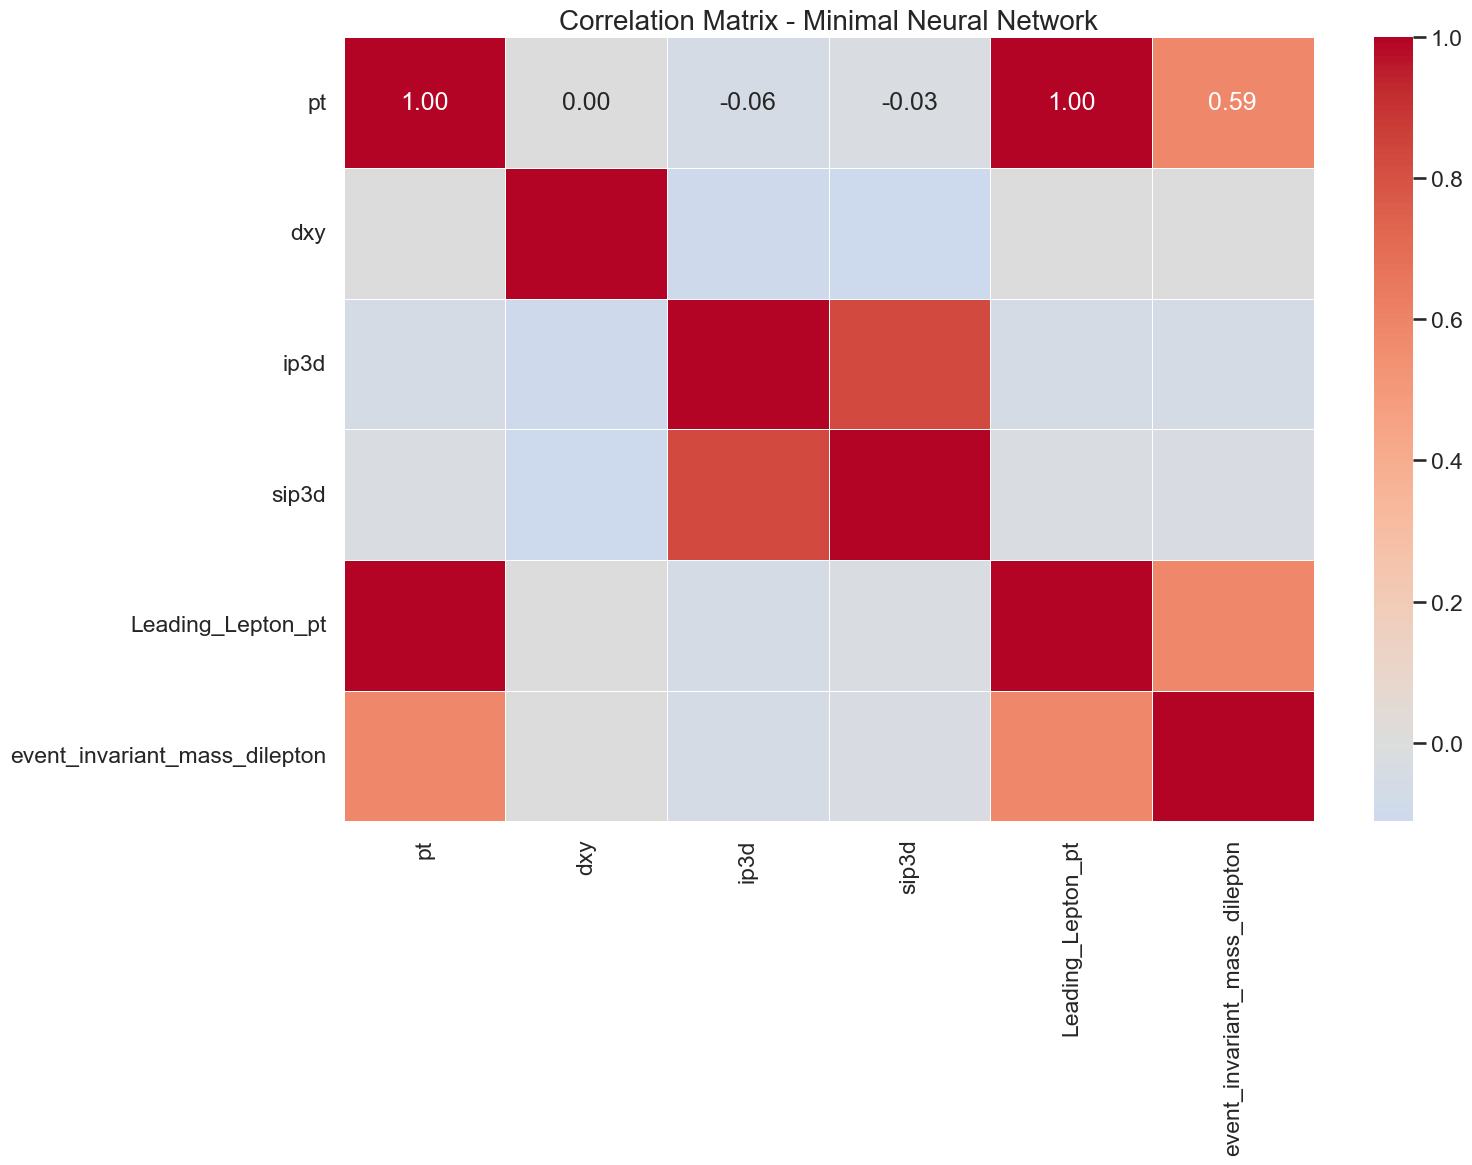

In [26]:
minimal_nn_vars = ['pt', 'dxy', 'ip3d', 'sip3d', 'Leading_Lepton_pt', 'event_invariant_mass_dilepton']
balanced_nn_vars = ['event_MET', 'Leading_Lepton_pt', 'pt', 'dxy', 'ip3d', 'jetNDauCharged']
plot_correlation_matrix(dfB, minimal_nn_vars, title='Correlation Matrix - Minimal Neural Network')

In [21]:
corr = dfB[minimal_nn_vars].corr()

# 看哪些是 NaN
print(corr.isna())

# 看是不是常数列
print(dfB[minimal_nn_vars].std())

                                  pt    dxy   ip3d  sip3d  Leading_Lepton_pt  \
pt                             False  False  False  False              False   
dxy                            False  False  False  False              False   
ip3d                           False  False  False  False              False   
sip3d                          False  False  False  False              False   
Leading_Lepton_pt              False  False  False  False              False   
event_invariant_mass_dilepton  False  False  False  False              False   

                               event_invariant_mass_dilepton  
pt                                                     False  
dxy                                                    False  
ip3d                                                   False  
sip3d                                                  False  
Leading_Lepton_pt                                      False  
event_invariant_mass_dilepton                          False 

In [20]:
#Build feature matrices
X_bkg=df_bkg[feature_cols].values
X_sig=df_sig[feature_cols].values

#Build labels
y_bkg=np.zeros(len(df_bkg), dtype=int)
y_sig=np.ones(len(df_sig), dtype=int)

#Concatenate into one dataset
X=np.vstack([X_bkg, X_sig])
y=np.concatenate([y_bkg, y_sig])

NameError: name 'df_bkg' is not defined

In [ ]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42,stratify=y)

#Scale features (fit on TRAIN only)
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled =scaler.transform(X_test)

#Split training into train_nn + validation
X_train_nn_scaled, X_val, y_train_nn, y_val = train_test_split(X_train_scaled, y_train,test_size=0.2,random_state=42,stratify=y_train)

print("Train_nn shape:", X_train_nn_scaled.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test_scaled.shape)

n_features=X_train_nn_scaled.shape[1]
print("n_features =", n_features)


## Plots

Sample of well-performing variable sets

In [ ]:
minimal_nn_vars = ['pt', 'dxy', 'ip3d', 'sip3d', 'Leading_Lepton_pt', 'event_invariant_mass_dilepton']
balanced_nn_vars = ['event_MET', 'Leading_Lepton_pt', 'pt', 'dxy', 'ip3d', 'jetNDauCharged']

In [ ]:
# plotting functions: plot_1d_signal_background, plot_sb_ratio, plot_2d, plot_correlation_matrix

sns.set(style="whitegrid", context="talk")

def get_weights(df, weight_col=None):
    """Return event weights if available, otherwise 1 for all events."""
    if weight_col is not None and weight_col in df.columns:
        return df[weight_col].values
    return np.ones(len(df))


def plot_1d_signal_background(dfS,
    dfB,
    var,
    weight_col=None,
    bins=40,
    range=None,
    logy=True, # default to log scale
    density=False,
    xlabel=None,
    title=None
):
    # 1D comparison of signal vs background for a single variable.
    # Produces a log-scale histogram with both shading and outlines.

    wS = get_weights(dfS, weight_col)
    wB = get_weights(dfB, weight_col)

    xS = dfS[var].values
    xB = dfB[var].values

    if range is None:
        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range = (lo, hi)

    plt.figure(figsize=(7, 5))

    # shaded background
    plt.hist(
        xB,
        bins=bins,
        range=range,
        weights=wB,
        density=density,
        alpha=0.1, # shading
        color="tab:blue"
    )

    # shaded signal
    plt.hist(
        xS,
        bins=bins,
        range=range,
        weights=wS,
        density=density,
        alpha=0.15,
        color="tab:orange" # shading
    )

    # outline background
    plt.hist(
        xB,
        bins=bins,
        range=range,
        weights=wB,
        density=density,
        histtype="step",
        color="tab:blue",
        linewidth=2,
        label="Background"
    )

    # outline signal
    plt.hist(
        xS,
        bins=bins,
        range=range,
        weights=wS,
        density=density,
        histtype="step",
        color="tab:orange",
        linewidth=2,
        linestyle="--",
        label="Signal"
    )

    # plotting
    plt.yscale("log")

    plt.xlabel(xlabel if xlabel is not None else var)
    plt.ylabel("Events (norm.)" if density else "Events")
    plt.legend()
    plt.tight_layout()
    if title:
        plt.title(title)
    plt.show()



def plot_sb_ratio(dfS, dfB, var, weight_col=None, bins=30, range=None, xlabel=None):
    wS = get_weights(dfS, weight_col)
    wB = get_weights(dfB, weight_col)

    xS = dfS[var].values
    xB = dfB[var].values

    if range is None:
        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range = (lo, hi)

    S, edges = np.histogram(xS, bins=bins, range=range, weights=wS)
    B, _     = np.histogram(xB, bins=bins, range=range, weights=wB)

    centers = 0.5 * (edges[:-1] + edges[1:])
    ratio = np.divide(S, B, out=np.zeros_like(S, dtype=float), where=B > 0)

    # plotting S/B
    plt.figure(figsize=(7, 4))

    plt.step(centers, ratio, where="mid", linewidth=2, linestyle="--", label="S/B")

    plt.xlabel(xlabel if xlabel is not None else var)
    plt.ylabel("S/B")
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.legend()
    plt.show()


def plot_2d(df, xvar, yvar, weight_col=None, bins=40, xlabel=None, ylabel=None, title=None):
    # 2D density plot for a single sample (do separately for S and B if needed).

    w = get_weights(df, weight_col)
    x = df[xvar].values
    y = df[yvar].values

    plt.figure(figsize=(7, 6))
    plt.hist2d(x, y, bins=bins, weights=w)
    plt.xlabel(xlabel if xlabel is not None else xvar)
    plt.ylabel(ylabel if ylabel is not None else yvar)
    if title:
        plt.title(title)
    plt.colorbar(label="Events")
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, var_list, title=''):
    # Filter variables that actually exist in the dataframe
    vars_available = [v for v in var_list if v in df.columns]

    # Compute correlation matrix
    corr_sub = df[vars_available].corr()

    # Plot
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        corr_sub,
        cmap="coolwarm",
        center=0,
        linewidths=0.5,
        annot=True,
        fmt=".2f",
        annot_kws={"size": 18}
    )
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_all_variables_stacked(dfS, dfB, var_list, weight_col=None, bins=40, title=''):
    n_vars = len(var_list)
    n_cols = 3
    n_var_rows = math.ceil(n_vars / n_cols)
    n_rows = 2 * n_var_rows  # 2 rows per variable row

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(7*n_cols, 4*n_rows))
    axes = np.array(axes)  # ensure 2D array

    # Flatten axes if needed
    if axes.ndim == 1:
        axes = axes[:, np.newaxis]

    for idx, var in enumerate(var_list):
        if var not in dfS.columns or var not in dfB.columns:
            print(f"Variable '{var}' not in both dfS and dfB. Skipping.")
            continue

        wS = get_weights(dfS, weight_col)
        wB = get_weights(dfB, weight_col)
        xS = dfS[var].values
        xB = dfB[var].values

        lo = np.nanpercentile(np.concatenate([xS, xB]), 1)
        hi = np.nanpercentile(np.concatenate([xS, xB]), 99)
        range_val = (lo, hi)

        # Compute row and column indices
        row_base = 2 * (idx // n_cols)
        col = idx % n_cols
        row_hist = row_base
        row_ratio = row_base + 1


        # Row 1: 1D histogram
        ax = axes[row_hist, col]
        ax.hist(xB, bins=bins, range=range_val, weights=wB, alpha=0.1, color="tab:blue")
        ax.hist(xS, bins=bins, range=range_val, weights=wS, alpha=0.15, color="tab:orange")
        ax.hist(xB, bins=bins, range=range_val, weights=wB, histtype="step", color="tab:blue", linewidth=2, label="Bkg")
        ax.hist(xS, bins=bins, range=range_val, weights=wS, histtype="step", color="tab:orange", linewidth=2, linestyle="--", label="Sig")
        ax.set_yscale("log")
        ax.set_ylabel("Events")
        ax.set_xlabel(var)
        if col == 0:
            ax.legend(fontsize=9)

        # Row 2: S/B ratio
        S, edges = np.histogram(xS, bins=bins, range=range_val, weights=wS)
        B, _ = np.histogram(xB, bins=bins, range=range_val, weights=wB)
        centers = 0.5 * (edges[:-1] + edges[1:])
        ratio = np.divide(S, B, out=np.zeros_like(S, dtype=float), where=B > 0)

        ax = axes[row_ratio, col]
        ax.step(centers, ratio, where="mid", linestyle="--", linewidth=2, label="S/B")
        ax.set_xlabel(var)
        ax.set_ylabel("S/B")
        ax.axhline(1, color='red', linestyle='--', linewidth=1, label="S/B = 1.0")  # horizontal reference line
        ax.grid(True, linestyle=":")
        if col == 0:
            ax.legend(fontsize=9)

    # Turn off any empty subplots
    total_axes = n_rows * n_cols
    for idx_empty in range(n_vars, n_var_rows * n_cols):
        row = 2 * (idx_empty // n_cols)
        col = idx_empty % n_cols
        if row < n_rows:
            axes[row, col].axis('off')
            axes[row + 1, col].axis('off')

    # Figure-level title
    if title:
        fig.suptitle(title, fontsize=18, y=1.02)

    plt.tight_layout()
    plt.show()


In [ ]:
mlp_vll = MLP(layer_sizes=[n_features, 128, 64, 2],activations=["relu", "relu"],l2=1e-3,seed=0)

history = train( mlp_vll,X_train_nn_scaled, y_train_nn,X_val, y_val,epochs=50,batch_size=256,lr=0.01,lr_decay=0.001,momentum=0.9,patience=10)

# Keras NN

In [ ]:
#Splitting Data
feature_cols = bkg.columns.tolist()
print(feature_cols)
X_bkg = bkg[feature_cols].values
X_sig = sig[feature_cols].values

Y_bkg = np.zeros(len(bkg), dtype=int) #
Y_sig = np.ones(len(sig), dtype=int)

X = np.vstack([X_bkg, X_sig])
Y = np.concatenate([Y_bkg, Y_sig])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#possible split for training with validation and testing
# feature_cols = [
#     'variable'
# ]

# # Build feature matrices for background and signal
# X_bkg = bkg[feature_cols].values
# X_sig = sig[feature_cols].values

# # Labels
# Y_bkg = np.zeros(len(bkg), dtype=int) #background
# Y_sig = np.ones(len(sig), dtype=int) #signal

# # Stack into one dataset
# X = np.vstack([X_bkg, X_sig])
# Y = np.concatenate([Y_bkg, Y_sig])

# #First split: training and validation  vs test  (80% / 20%)
# X_train_val, X_test, Y_train_val, Y_test = train_test_split(
#     X,
#     Y,
#     test_size=0.2,
#     random_state=42,
#     stratify=Y
# )

# #Second split: train vs validation  (from the 80% to 60% / 20%)
# #Overall: 60% train, 20% val, 20% test
# X_train, X_val, Y_train, Y_val = train_test_split(
#     X_train_val,
#     Y_train_val,
#     test_size=0.25,        # 0.25 of 0.8 = 0.2 of total
#     random_state=42,
#     stratify=Y_train_val
# )

# #Scaling features/variables: fit only on train, apply to validation and test
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)

# #Class balancing for background and signal for different sizes
# from sklearn.utils.class_weight import compute_class_weight

# classes = np.unique(Y_train)
# class_weights = compute_class_weight('balanced', classes=classes, y=Y_train)
# class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

# print("Class weights:", class_weight_dict)



## Building MLP

In [ ]:
def build_mlp(input_dim):
    model = keras.Sequential([
        layers.Dense(
            128,
            activation="relu",
            kernel_regularizer=regularizers.l2(1e-4),
            input_shape=(input_dim,)
        ),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),

        layers.Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.AUC(name="auc")]
    )

    return model

class LrTracker(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs["lr"] = self.model.optimizer.learning_rate.numpy()

lr_tracker = LrTracker()

In [ ]:
model = build_mlp(X_train_scaled.shape[1])
model.summary()

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history = model.fit(
    X_train_scaled, Y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[lr_tracker, reduce_lr],
    verbose=1
)

## Training Curves

In [ ]:
# loss
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# learning rate
plt.figure(figsize=(7,5))
plt.plot(history.history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

In [ ]:
# accuracy
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_pred = model.predict(X_test_scaled)
print(y_pred[:20])

In [ ]:
y_label = (y_pred > 0.5).astype(int)
print(y_label[:20])

In [ ]:
y_pred = model.predict(X_test_scaled).flatten()

plt.figure(figsize=(7,5))
plt.hist(y_pred[Y_test==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_pred[Y_test==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel("MLP Score (Signal Probability)")
plt.ylabel("Density")
plt.legend()
plt.title("MLP Output Score Distribution")
plt.show()

### Classification Report

In [ ]:
y_pred_label = (y_pred > 0.5).astype(int)
acc = accuracy_score(Y_test, y_pred_label)
print("\nClassification report at threshold 0.5:")
print(classification_report(Y_test, y_pred_label, digits=3))
print("Test Accuracy:", acc)

In [ ]:
df_output = pd.DataFrame({
    "TrueLabel": Y_test.flatten(),
    "PredictedProb": y_pred,
    "PredLabel": y_pred_label.flatten()
})

print(df_output.head(50))

## ROC curve and AUC

In [ ]:
#Basic Evals:
# basic tests with keras
test_loss, test_acc, test_auc = model.evaluate(X_test_scaled, Y_test, verbose=0)
print(f"Test loss      : {test_loss:.4f}")
print(f"Test accuracy  : {test_acc:.4f}")
print(f"Test AUC (ROC) : {test_auc:.4f}")

# Predicted probabilities (NN scores) on the test set
# Probability of signal vs features for each event
y_test_proba = model.predict(X_test_scaled).ravel()

# ROC curve on the test set
fpr, tpr, thresholds = roc_curve(Y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.xlabel('False positive rate (background efficiency)')
plt.ylabel('True positive rate (signal efficiency)')
plt.title('Test ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Score distributions for signal vs background
plt.figure(figsize=(6, 5))
plt.hist(
    y_test_proba[Y_test == 0],
    bins=30,
    alpha=0.6,
    density=True,
    label='Background (ttbar)'
)
plt.hist(
    y_test_proba[Y_test == 1],
    bins=30,
    alpha=0.6,
    density=True,
    label='Signal (VLL)'
)
plt.xlabel('NN score (P(signal))')
plt.ylabel('Normalized counts')
plt.title('NN score distributions on test set')
plt.legend()
plt.grid(True)
plt.show()

#confusion matrix at a 0.5 threshold
y_test_pred = (y_test_proba >= 0.5).astype(int)
cm = confusion_matrix(Y_test, y_test_pred)
print("Confusion matrix at threshold 0.5:\n", cm)

## Z Score, threshold scanning, and efficiency of signal and background

In [ ]:
#Threshold scanning and evaluation of MLP:
#optimizing and threshold scanning: where should we cut our NN to determine whether something is a signal or background

# Total signal and background in the test set
S0 = np.sum(Y_test == 1)
B0 = np.sum(Y_test == 0)
print(f"Total test signal S0 = {S0}, background B0 = {B0}")

# Threshold grid to scan
thresholds = np.linspace(0.0, 1.0, 200) #200 thresholds between 0 and 1

S_vals = []
B_vals = []
S_eff = []  # signal efficiency epsilon_S(t)
B_eff = []         # background efficiency epsilon_B(t)
S_over_B = []        # S/B(t)
S_over_sqrt_SPB = []    # S/sqrt(S+B)(t) = Z(t)

for t in thresholds:
    sel = (y_test_proba >= t)

    S = np.sum((Y_test == 1) & sel)
    B = np.sum((Y_test == 0) & sel)

    S_vals.append(S)
    B_vals.append(B)

    S_eff.append(S / S0 if S0 > 0 else 0.0)
    B_eff.append(B / B0 if B0 > 0 else 0.0)

    if B > 0:
        S_over_B.append(S / B)
    else:
        S_over_B.append(np.nan)

    if (S + B) > 0:
        S_over_sqrt_SPB.append(S / np.sqrt(S + B))
    else:
        S_over_sqrt_SPB.append(0.0)

S_vals = np.array(S_vals)
B_vals = np.array(B_vals)
S_eff = np.array(S_eff)
B_eff = np.array(B_eff)
S_over_B = np.array(S_over_B)
S_over_sqrt_SPB = np.array(S_over_sqrt_SPB)

# Find best thresholds
idx_best_SB = np.nanargmax(S_over_B)
idx_best_Z  = np.argmax(S_over_sqrt_SPB)

print(f"\nBest S/B at threshold t = {thresholds[idx_best_SB]:.3f}")
print(f"  S = {S_vals[idx_best_SB]}, B = {B_vals[idx_best_SB]}, S/B = {S_over_B[idx_best_SB]:.3f}")

print(f"\nBest S/sqrt(S+B) at threshold t = {thresholds[idx_best_Z]:.3f}")
print(f"  S = {S_vals[idx_best_Z]}, B = {B_vals[idx_best_Z]}, Z = {S_over_sqrt_SPB[idx_best_Z]:.3f}")

# PLotting:

# Signal efficiency vs background rejection
plt.figure(figsize=(6,5))
plt.plot(1 - B_eff, S_eff, label='Scan over thresholds')
plt.xlabel('Background rejection = 1 - epsilon_B(t)')
plt.ylabel('Signal efficiency ε_S(t)')
plt.title('Signal efficiency vs background rejection')
plt.grid(True)
plt.legend()
plt.show()

# S/B vs threshold
plt.figure(figsize=(6,5))
plt.plot(thresholds, S_over_B, label='S/B(t)')
plt.axvline(thresholds[idx_best_SB], color='r', linestyle='--',
            label=f'Best S/B t={thresholds[idx_best_SB]:.3f}')
plt.xlabel('NN score threshold t')
plt.ylabel('S/B')
plt.title('S/B as function of NN threshold')
plt.grid(True)
plt.legend()
plt.show()

# S/sqrt(S+B) vs threshold
plt.figure(figsize=(6,5))
plt.plot(thresholds, S_over_sqrt_SPB, label='S/sqrt(S+B)(t)')
plt.axvline(thresholds[idx_best_Z], color='r', linestyle='--',
            label=f'Best Z t={thresholds[idx_best_Z]:.3f}')
plt.xlabel('NN score threshold t')
plt.ylabel('S / sqrt(S + B)')
plt.title('Toy significance vs NN threshold')
plt.grid(True)
plt.legend()
plt.show()


### KS Testing for signal overtraining

In [ ]:
#KS Prob test for Signal overtrainng:
train_sig_scores = model.predict(X_train_scaled[Y_train == 1]).ravel()
test_sig_scores  = model.predict(X_test_scaled[Y_test == 1]).ravel()

D_sig, p_sig = ks_2samp(train_sig_scores, test_sig_scores)

print(f"Signal KS statistic D = {D_sig:.3f}")
print(f"Signal KS p-value = {p_sig:.3g}")


In [ ]:
#KS Prob test for Background overtrianing:
train_bkg_scores = model.predict(X_train_scaled[Y_train == 0]).ravel()
test_bkg_scores  = model.predict(X_test_scaled[Y_test == 0]).ravel()

D_bkg, p_bkg = ks_2samp(train_bkg_scores, test_bkg_scores)

print(f"Background KS statistic D = {D_bkg:.3f}")
print(f"Background KS p-value = {p_bkg:.3g}")

In [ ]:
# Compare Signal vs Background score distributions
sig_scores = model.predict(X_test_scaled[Y_test == 1]).ravel()
bkg_scores = model.predict(X_test_scaled[Y_test == 0]).ravel()

D_sb, p_sb = ks_2samp(sig_scores, bkg_scores)

print(f"Signal vs Background KS statistic D = {D_sb:.3f}")
print(f"Background KS p-value = {p_sb:.3g}")

# Different Channels (EE, EN, NN)

## EE Channel

In [ ]:
#Splitting Data
feature_cols = bkg.columns.tolist() #using all features
print(feature_cols)
#using same background signal as before, here for context:
#X_bkg = bkg[feature_cols].values
X_EE_sig = EE_sig[feature_cols].values #using new EE signal

#Y_bkg = np.zeros(len(bkg), dtype=int) #using same background name
Y_EE_sig = np.ones(len(EE_sig), dtype=int)

X_EE = np.vstack([X_bkg, X_EE_sig])
Y_EE = np.concatenate([Y_bkg, Y_EE_sig])

X_EE_train, X_EE_test, Y_EE_train, Y_EE_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_EE_train_scaled = scaler.fit_transform(X_EE_train)
X_EE_test_scaled = scaler.transform(X_EE_test)

In [ ]:
model_EE = build_mlp(X_EE_train_scaled.shape[1])
model_EE.summary()

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_EE = model_EE.fit(
    X_EE_train_scaled, Y_EE_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[lr_tracker, reduce_lr],
    verbose=1
)

### EE Training Curves

In [ ]:
# loss
plt.figure(figsize=(7,5))
plt.plot(history_EE.history['loss'], label='Training Loss')
plt.plot(history_EE.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# accuracy
plt.figure(figsize=(7,5))
plt.plot(history_EE.history['accuracy'], label='Training Accuracy')
plt.plot(history_EE.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_EE_pred = model_EE.predict(X_EE_test_scaled)
y_EE_label = (y_EE_pred > 0.5).astype(int)

y_EE_pred = model_EE.predict(X_EE_test_scaled).flatten()

plt.figure(figsize=(7,5))
plt.hist(y_EE_pred[Y_EE_test==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_EE_pred[Y_EE_test==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel("MLP Score (Signal Probability)")
plt.ylabel("Density")
plt.legend()
plt.title("MLP Output Score Distribution")
plt.show()

### EE Classification Report

In [ ]:
y_EE_pred_label = (y_EE_pred > 0.5).astype(int)
acc_EE = accuracy_score(Y_EE_test, y_EE_pred_label)
print("\nClassification report at threshold 0.5:")
print(classification_report(Y_EE_test, y_EE_pred_label, digits=3))
print("Test Accuracy:", acc_EE)

## EN Channel

In [ ]:
#Splitting Data
feature_cols = bkg.columns.tolist() #using all features
print(feature_cols)
#using same background signal as before, here for context:
#X_bkg = bkg[feature_cols].values
X_EN_sig = EN_sig[feature_cols].values #using new EN signal

#Y_bkg = np.zeros(len(bkg), dtype=int) #using same background name
Y_EN_sig = np.ones(len(EN_sig), dtype=int)

X_EN = np.vstack([X_bkg, X_EN_sig])
Y_EN = np.concatenate([Y_bkg, Y_EN_sig])

X_EN_train, X_EN_test, Y_EN_train, Y_EN_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_EN_train_scaled = scaler.fit_transform(X_EN_train)
X_EN_test_scaled = scaler.transform(X_EN_test)

In [ ]:
model_EN = build_mlp(X_EN_train_scaled.shape[1])
model_EN.summary()

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_EN = model_EN.fit(
    X_EN_train_scaled, Y_EN_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[lr_tracker, reduce_lr],
    verbose=1
)

### EN Training Curves

In [ ]:
# loss
plt.figure(figsize=(7,5))
plt.plot(history_EN.history['loss'], label='Training Loss')
plt.plot(history_EN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# accuracy
plt.figure(figsize=(7,5))
plt.plot(history_EN.history['accuracy'], label='Training Accuracy')
plt.plot(history_EN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_EN_pred = model_EN.predict(X_EN_test_scaled)
y_EN_label = (y_EN_pred > 0.5).astype(int)

y_EN_pred = model_EN.predict(X_EN_test_scaled).flatten()

plt.figure(figsize=(7,5))
plt.hist(y_EN_pred[Y_EN_test==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_EN_pred[Y_EN_test==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel("MLP Score (Signal Probability)")
plt.ylabel("Density")
plt.legend()
plt.title("MLP Output Score Distribution")
plt.show()

### EN Classifcation Report

In [ ]:
y_EN_pred_label = (y_EN_pred > 0.5).astype(int)
acc_EN = accuracy_score(Y_EN_test, y_EN_pred_label)
print("\nClassification report at threshold 0.5:")
print(classification_report(Y_EN_test, y_EN_pred_label, digits=3))
print("Test Accuracy:", acc_EN)

## NN Channel

In [ ]:
#Splitting Data
feature_cols = bkg.columns.tolist() #using all features
print(feature_cols)
#using same background signal as before, here for context:
#X_bkg = bkg[feature_cols].values
X_NN_sig = NN_sig[feature_cols].values #using new NN signal

#Y_bkg = np.zeros(len(bkg), dtype=int) #using same background name
Y_NN_sig = np.ones(len(NN_sig), dtype=int)

X_NN = np.vstack([X_bkg, X_NN_sig])
Y_NN = np.concatenate([Y_bkg, Y_NN_sig])

X_NN_train, X_NN_test, Y_NN_train, Y_NN_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_NN_train_scaled = scaler.fit_transform(X_NN_train)
X_NN_test_scaled = scaler.transform(X_NN_test)

In [ ]:
model_NN = build_mlp(X_NN_train_scaled.shape[1])
model_NN.summary()

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

history_NN = model_NN.fit(
    X_NN_train_scaled, Y_NN_train,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    callbacks=[lr_tracker, reduce_lr],
    verbose=1
)

### NN Training Curves

In [ ]:
# loss
plt.figure(figsize=(7,5))
plt.plot(history_NN.history['loss'], label='Training Loss')
plt.plot(history_NN.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# accuracy
plt.figure(figsize=(7,5))
plt.plot(history_NN.history['accuracy'], label='Training Accuracy')
plt.plot(history_NN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
y_NN_pred = model_NN.predict(X_NN_test_scaled)
y_NN_label = (y_NN_pred > 0.5).astype(int)

y_NN_pred = model_NN.predict(X_NN_test_scaled).flatten()

plt.figure(figsize=(7,5))
plt.hist(y_NN_pred[Y_NN_test==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_NN_pred[Y_NN_test==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel("MLP Score (Signal Probability)")
plt.ylabel("Density")
plt.legend()
plt.title("MLP Output Score Distribution")
plt.show()

### NN Classification Report

In [ ]:
y_NN_pred_label = (y_NN_pred > 0.5).astype(int)
acc_NN = accuracy_score(Y_NN_test, y_NN_pred_label)
print("\nClassification report at threshold 0.5:")
print(classification_report(Y_NN_test, y_NN_pred_label, digits=3))
print("Test Accuracy:", acc_NN)

# Z score, Signal to background ratio based on threshold used

In [ ]:
#function for getting threshold information: ratios and efficiency
def scan_thresholds(y_true, y_proba, thresholds=None):
    #Perform threshold scan for a given channel (or model output).
    #Returns a dict with all relevant arrays for later plotting/comparison.

    #y_true : array of true labels (0 = background, 1 = signal)
    #y_proba  : array of predicted probabilities (NN score in [0,1])
    #thresholds : array of thresholds to scan; if None, defaults to 200 points in [0,1]

    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 200)
    thresholds = np.asarray(thresholds)

    #Total signal and background in test set
    S0 = np.sum(y_true == 1)
    B0 = np.sum(y_true == 0)

    S_vals = []
    B_vals = []
    S_eff = []              # (2) ε_S(t) = S(t) / S0
    B_eff = []              # (3) ε_B(t) = B(t) / B0
    S_over_B = []           # (4) S/B(t)
    S_over_sqrt_SPB = []    # (5) Z(t) = S / sqrt(S + B)

    for t in thresholds:
        sel = (y_proba >= t)

        #S(t) and B(t) at given threshold t
        S = np.sum((y_true == 1) & sel)
        B = np.sum((y_true == 0) & sel)

        S_vals.append(S)
        B_vals.append(B)

        S_eff.append(S / S0 if S0 > 0 else 0.0)
        B_eff.append(B / B0 if B0 > 0 else 0.0)

        if B > 0:
            S_over_B.append(S / B)
        else:
            S_over_B.append(np.nan)

        if (S + B) > 0:
            S_over_sqrt_SPB.append(S / np.sqrt(S + B))
        else:
            S_over_sqrt_SPB.append(0.0)

    S_vals = np.array(S_vals)
    B_vals = np.array(B_vals)
    S_eff = np.array(S_eff)
    B_eff = np.array(B_eff)
    S_over_B = np.array(S_over_B)
    S_over_sqrt_SPB = np.array(S_over_sqrt_SPB)

    #Best thresholds
    idx_best_SB = np.nanargmax(S_over_B)
    idx_best_Z  = np.argmax(S_over_sqrt_SPB)

    results = {
        "thresholds": thresholds,
        "S0": S0,
        "B0": B0,
        "S_vals": S_vals,
        "B_vals": B_vals,
        "S_eff": S_eff,
        "B_eff": B_eff,
        "S_over_B": S_over_B,
        "Z": S_over_sqrt_SPB,
        "idx_best_SB": idx_best_SB,
        "idx_best_Z": idx_best_Z,
        "t_best_SB": thresholds[idx_best_SB],
        "t_best_Z": thresholds[idx_best_Z],
    }

    return results


In [ ]:
#Function for plotting scores and thresholds:
def plot_threshold_results(results, label=""):
    thresholds = results["thresholds"]
    S_eff      = results["S_eff"]
    B_eff      = results["B_eff"]
    S_over_B   = results["S_over_B"]
    Z          = results["Z"]
    idx_best_SB = results["idx_best_SB"]
    idx_best_Z  = results["idx_best_Z"]

    # Signal efficiency vs background rejection
    plt.figure(figsize=(6,5))
    plt.plot(1 - B_eff, S_eff, label=f'{label}')
    plt.xlabel('Background rejection = 1 - ε_B(t)')
    plt.ylabel('Signal efficiency ε_S(t)')
    plt.title(f'{label}: Signal efficiency vs background rejection')
    plt.grid(True)
    plt.legend()
    plt.show()

    # S/B vs threshold
    plt.figure(figsize=(6,5))
    plt.plot(thresholds, S_over_B, label='S/B(t)')
    plt.axvline(thresholds[idx_best_SB], linestyle='--',
                label=f'Best S/B t={thresholds[idx_best_SB]:.3f}')
    plt.xlabel('NN score threshold t')
    plt.ylabel('S/B')
    plt.title(f'{label}: S/B as function of NN threshold')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Z = S/sqrt(S+B) vs threshold (Z score)
    plt.figure(figsize=(6,5))
    plt.plot(thresholds, Z, label='S/sqrt(S+B)(t)')
    plt.axvline(thresholds[idx_best_Z], linestyle='--',
                label=f'Best Z t={thresholds[idx_best_Z]:.3f}')
    plt.xlabel('NN score threshold t')
    plt.ylabel('S / sqrt(S + B)')
    plt.title(f'{label}: Toy significance vs NN threshold')
    plt.grid(True)
    plt.legend()
    plt.show()


## EE Scores:

In [ ]:
y_EE_test_proba = model_EE.predict(X_EE_test_scaled).ravel()
results_EE = scan_thresholds(Y_EE_test, y_EE_test_proba)
plot_threshold_results(results_EE, label="EE channel")

## EN SCores

In [ ]:
y_EN_test_proba = model_EN.predict(X_EN_test_scaled).ravel()
results_EN = scan_thresholds(Y_EN_test, y_EN_test_proba)
plot_threshold_results(results_EN, label="EN channel")

## NN Scores

In [ ]:
y_NN_test_proba = model_NN.predict(X_NN_test_scaled).ravel()
results_NN = scan_thresholds(Y_NN_test, y_NN_test_proba)
plot_threshold_results(results_NN, label="NN channel")

## KS Probability Test for EE, EN, and NN Channels

In [ ]:
import numpy as np
from scipy.stats import ks_2samp

def evaluate_all_channels(
    channels,
    thresholds=None,
    verbose=True
):
    """
    Run full evaluation suite for EE, EN, NN channels.

    Parameters
    ----------
    channels : dict
        Dictionary of the form:
        {
            "EE": {"y_true": ..., "scores": ...},
            "EN": {"y_true": ..., "scores": ...},
            "NN": {"y_true": ..., "scores": ...},
        }

    thresholds : array-like, optional
        Thresholds to scan for S/B and significance.
        Defaults to np.linspace(0,1,200)

    verbose : bool
        If True, prints formatted results.

    Returns
    -------
    results : dict
        Nested dictionary with KS tests and threshold-scan metrics.
    """

    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 200)

    results = {
        "cross_channel_KS": {},
        "signal_background_KS": {},
        "threshold_scans": {}
    }

    channel_names = list(channels.keys())

    # ---------------------------------------------------------
    # (1) Cross-channel KS tests
    # ---------------------------------------------------------
    for i in range(len(channel_names)):
        for j in range(i + 1, len(channel_names)):
            c1, c2 = channel_names[i], channel_names[j]
            D, p = ks_2samp(channels[c1]["scores"], channels[c2]["scores"])
            results["cross_channel_KS"][(c1, c2)] = {"D": D, "p": p}

            if verbose:
                print(f"{c1} vs {c2}: KS D = {D:.3f}, p = {p:.3g}")

    if verbose:
        print("\n" + "-" * 60)

    # ---------------------------------------------------------
    # (2) Signal vs Background KS per channel
    # ---------------------------------------------------------
    for name, data in channels.items():
        y_true = data["y_true"]
        scores = data["scores"]

        sig_scores = scores[y_true == 1]
        bkg_scores = scores[y_true == 0]

        D, p = ks_2samp(sig_scores, bkg_scores)
        results["signal_background_KS"][name] = {"D": D, "p": p}

        if verbose:
            print(f"{name}: Signal vs Background KS D = {D:.3f}, p = {p:.3g}")

    if verbose:
        print("\n" + "-" * 60)

    # ---------------------------------------------------------
    # (3) Threshold scans
    # ---------------------------------------------------------
    for name, data in channels.items():
        y_true = data["y_true"]
        scores = data["scores"]

        S0 = np.sum(y_true == 1)
        B0 = np.sum(y_true == 0)

        S_vals, B_vals = [], []
        S_eff, B_eff = [], []
        S_over_B, Z = [], []

        for t in thresholds:
            sel = scores >= t
            S = np.sum((y_true == 1) & sel)
            B = np.sum((y_true == 0) & sel)

            S_vals.append(S)
            B_vals.append(B)

            S_eff.append(S / S0 if S0 > 0 else 0)
            B_eff.append(B / B0 if B0 > 0 else 0)

            S_over_B.append(S / B if B > 0 else np.nan)
            Z.append(S / np.sqrt(S + B) if (S + B) > 0 else 0)

        S_over_B = np.array(S_over_B)
        Z = np.array(Z)

        idx_best_SB = np.nanargmax(S_over_B)
        idx_best_Z = np.argmax(Z)

        results["threshold_scans"][name] = {
            "thresholds": thresholds,
            "S_eff": np.array(S_eff),
            "B_eff": np.array(B_eff),
            "S_over_B": S_over_B,
            "Z": Z,
            "best_SB": {
                "threshold": thresholds[idx_best_SB],
                "value": S_over_B[idx_best_SB],
            },
            "best_Z": {
                "threshold": thresholds[idx_best_Z],
                "value": Z[idx_best_Z],
            },
        }

        if verbose:
            print(
                f"{name}: "
                f"best S/B @ t={thresholds[idx_best_SB]:.3f}, "
                f"best Z @ t={thresholds[idx_best_Z]:.3f}"
            )

    return results

In [ ]:
channels = {
    "EE": {"y_true": Y_EE_test, "scores": scores_EE},
    "EN": {"y_true": Y_EN_test, "scores": scores_EN},
    "NN": {"y_true": Y_NN_test, "scores": scores_NN},
}

results = evaluate_all_channels(channels)


In [ ]:
from scipy.stats import ks_2samp

print("\n==================== KS TEST: CROSS-CHANNEL ====================\n")

# --- (1) Helper function for clean printing ---
def KS_compare(scores_a, scores_b, name_a, name_b):
    D, p = ks_2samp(scores_a, scores_b)
    print(f"{name_a} vs {name_b}:  KS D = {D:.3f},  p = {p:.3g}")
    return D, p

# --- (2) Extract classifier score distributions for each channel ---
scores_EE = y_EE_test_proba
scores_EN = y_EN_test_proba
scores_NN = y_NN_test_proba

print("Comparing score distributions between channels:\n")

# EE vs EN
KS_compare(scores_EE, scores_EN, "EE", "EN")

# EE vs NN
KS_compare(scores_EE, scores_NN, "EE", "NN")

# EN vs NN
KS_compare(scores_EN, scores_NN, "EN", "NN")

print("\n-------------------- KS TEST: S/B per channel -------------------\n")

# --- (3) Signal-vs-Background KS Test for each channel ---

def KS_signal_background(y_true, y_proba, channel_name):
    sig_scores = y_proba[y_true == 1]
    bkg_scores = y_proba[y_true == 0]
    D, p = ks_2samp(sig_scores, bkg_scores)
    print(f"{channel_name}: Signal vs Background  KS D = {D:.3f},  p = {p:.3g}")
    return D, p

KS_signal_background(Y_EE_test, scores_EE, "EE")
KS_signal_background(Y_EN_test, scores_EN, "EN")
KS_signal_background(Y_NN_test, scores_NN, "NN")


## Combined original, EE, EN, and NN

In [ ]:
results_orig = scan_thresholds(Y_test,       y_test_proba,       thresholds=None)
results_EE   = scan_thresholds(Y_EE_test,   y_EE_test_proba,    thresholds=results_orig["thresholds"])
results_EN   = scan_thresholds(Y_EN_test,   y_EN_test_proba,    thresholds=results_orig["thresholds"])
results_NN   = scan_thresholds(Y_NN_test,   y_NN_test_proba,    thresholds=results_orig["thresholds"])

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(results_orig["thresholds"], results_orig["Z"], label="Original")
plt.plot(results_EE["thresholds"],   results_EE["Z"],   label="EE")
plt.plot(results_EN["thresholds"],   results_EN["Z"],   label="EN")
plt.plot(results_NN["thresholds"],   results_NN["Z"],   label="NN")
plt.xlabel('NN score threshold t')
plt.ylabel('S / sqrt(S + B)')
plt.title('Toy significance vs Neural Network threshold for all channels')
plt.grid(True)
plt.legend()
plt.show()


### S/B ratio plot combined all channels

In [ ]:
plt.figure(figsize=(7,5))

plt.plot(thresholds, results_orig["S_over_B"], label="Original")
plt.plot(thresholds, results_EE["S_over_B"],   label="EE")
plt.plot(thresholds, results_EN["S_over_B"],   label="EN")
plt.plot(thresholds, results_NN["S_over_B"],   label="NN")

plt.xlabel("NN score threshold t")
plt.ylabel("S / B")  # (2) S/B(t) = S(t) / B(t)
plt.title("S/B vs NN threshold for all channels")
plt.grid(True)
plt.legend()
plt.show()
